In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
import pandas as pd
import scipy.stats as st
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.signal import find_peaks
import os
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

# load parameters
parameters_file = r'/Users/kowens2/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/Monolix/NBA Cohort/Projects/FitAllInfectionsAppendNegatives/T0_1x107_E0_0_I0_0_V0_est/IndividualParameters/estimatedIndividualParameters.txt'
parameters_df=pd.read_csv(parameters_file)

# load data
full_data_file = r'/Users/kowens2/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/Monolix/NBA Cohort/Data/NBA_1510infections.csv'
full_data_df = pd.read_csv(full_data_file)

# list unique infection IDs
IDs = parameters_df.id.unique()

In [2]:
# Functions for simulation
def GetParams(parameters_df, ID, style = 'mode'):
    ''' 
    input:
        - data frame with parameter values as columns, individuals as rows
        - ID identifying individual of interest
        - style = 'mode' or 'mean' or 'SAEM' depending on which parameter values are preferred
    return:
        - dictionary with parameter names as key and parameter values as values
    '''
    i = ID
    cols = list(parameters_df)
    pid_params = parameters_df[parameters_df.id == i].copy()
    values = []
    keys = []
    for c in cols:
        if style in c:
            k = c.split('_')[0]
            keys.append(k)
            v = pid_params[c].values[0]
            values.append(v)
        for i,(v,k) in enumerate(zip(values, keys)):
            if 'log10' in k:
                values[i] = 10**v
                keys[i] = k.split('0')[1]

    params = dict(zip(keys, values))
    return params

def Simulate(func, param_order, param_dict, init, tend, N):
    '''
    input: 
        - func is a function that takes in the state variable, time and parameters and returns the derivative
        - params is a dictionary of the parameter values 
        - init is a dictionary of the initial condition to simulate from 
    return: 
        - trajectory simulated from init for tspan using func with given params
    '''
    # make parameter list in correct order
    params = []
    for k in param_order:
        params.append(param_dict[k])
    # extract initial time
    if 'tzero' in param_dict:
        t0 = -param_dict['tzero']
    else:
        t0 = 0 
    # build tspan
    tspan = np.linspace(t0,tend,N)
    # incorporate V0
    V0 = param_dict['V0']
    init[4] = V0
    # simulate using scipy integrate
    y = spi.odeint(func, init, tspan, args = tuple(params))
    return tspan,y
# Put fixed paramters in a dictionary
fixed_params = dict({'c': 15, 'k':4})
T_0 = 10**7
R_0 = 0;
E_0 = 0;
I_0 = 0;
V_0 = 0;
init = [T_0, R_0, E_0, I_0, V_0]

# Write function for model simulation
def deriv(y, t, beta, phi, rho, k, delta,h, m, pi, c,tAI):
    T,R,E,I,V = y
    
    if t > tAI:
        eps = m
    else:
        eps = 0
        
    ddt_T = -beta*T*V - phi*I*T + rho*R
    ddt_R = phi*I*T -rho*R
    ddt_E = beta*T*V - k*E
    ddt_I = k*E - delta*np.maximum(I,.000001)**h*I - eps*I
    if I >= 1:
        ddt_V = pi*I-c*V
    else:
        ddt_V = -c*V

    return ddt_T, ddt_R, ddt_E, ddt_I, ddt_V

param_order = ['beta', 'phi', 'rho', 'k', 'delta','h', 'm', 'pi', 'c', 'tAI']

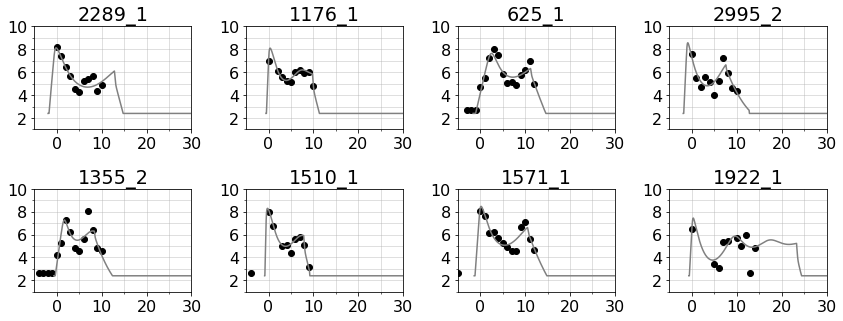

In [3]:
# Look at some examples of rebound
ExampleRebound = ['2289_1','1176_1', '625_1', '2995_2','1355_2',
                '1510_1', '1571_1','1922_1', '447_1','2775_1']

plt.rcParams.update({'font.size': 16})
count = 0
fig, ax = plt.subplots(2,4, figsize =(12,4.75))
for j in range(0,2):
    for jj in range(0,4):
        if count < len(ExampleRebound):
            try:
                ID = ExampleRebound[count]
                ind_params = GetParams(parameters_df, ID, style = 'mode')
                params_dict = {**fixed_params, **ind_params}
                t,y = Simulate(deriv, param_order, params_dict, init, 40, 10000)
                
                # identify data
                tdata = full_data_df[full_data_df['ID'] == ID].time
                temp = full_data_df[full_data_df['ID'] == ID].y
                ydata = [float(y) for y in temp]
                ax[j,jj].plot(tdata.values, ydata,'o', color = 'black')
                ax[j,jj].plot(t, np.log10(np.maximum(y[:,4],250)), color = 'gray')
                ax[j,jj].set_ylim(1,9.5)
                ax[j,jj].set_xlim(-5,30)
                ax[j,jj].set_title(ID)
                major_ticks = np.arange(2, 11, 2)
                minor_ticks = np.arange(1, 11, 1)
                ax[j,jj].set_yticks(major_ticks)
                ax[j,jj].set_yticks(minor_ticks, minor=True)
                ax[j,jj].set_xticks(np.arange(0, 35, 10))
                ax[j,jj].set_xticks(np.arange(0, 35, 5), minor=True)
                ax[j,jj].grid(which='both',alpha = .5)
                count = count + 1
            except:
                ax[j,jj].set_title(ID)
                count = count+1
                continue

plt.tight_layout()

## Flag cases with two peaks as rebound

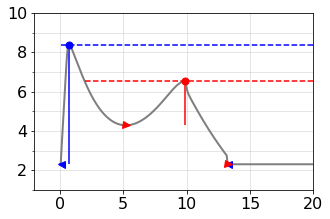

In [4]:
# Illustrate rebound criteria
fig, ax = plt.subplots(figsize = (5,3.25))
i ='2775_1'
ind_params = GetParams(parameters_df, i, style = 'mode')
params_dict = {**fixed_params, **ind_params}
tzero = -params_dict['tzero']
N = 5000
t,y = Simulate(deriv, param_order, params_dict, init, 50+tzero, N);
t = t - t[0]
I = y[:,3]
V = y[:,4]
peaks, props = find_peaks(np.log10(np.maximum(V,200)), height = 3, prominence = 1)
left_bases = props['left_bases']
right_bases = props['right_bases']
plt.plot(t,np.log10(np.maximum(V,200)),'tab:gray', lw = 2)
plt.plot(t[peaks[0]], np.log10(np.maximum(V[peaks[0]],200)), "bo", markersize =7)
plt.plot(t[left_bases[0]], np.log10(np.maximum(V[left_bases[0]],200)), "b<", markersize = 7)
plt.plot(t[right_bases[0]], np.log10(np.maximum(V[right_bases[0]],200)), "b<", markersize = 7)
plt.plot([t[left_bases[0]], 20],[np.log10(np.maximum(V[peaks[0]],200)),np.log10(np.maximum(V[peaks[0]],200))],'b--' )
plt.plot(t[peaks[1]], np.log10(np.maximum(V[peaks[1]],200)), "ro", markersize =7)
plt.plot(t[left_bases[1]], np.log10(np.maximum(V[left_bases[1]],200)), "r>", markersize = 7)
plt.plot(t[right_bases[1]], np.log10(np.maximum(V[right_bases[1]],200)), "r>", markersize = 7)
plt.plot([t[200], 20],[np.log10(np.maximum(V[peaks[1]],200)),np.log10(np.maximum(V[peaks[1]],200))],'r--' )
plt.vlines(x=t[peaks[0]], ymin=np.log10(np.maximum(V[peaks[0]],200)) - props["prominences"][0],
           ymax = np.log10(np.maximum(V[peaks[0]],200)), color = "b")
plt.vlines(x=t[peaks[1]], ymin=np.log10(np.maximum(V[peaks[1]],200)) - props["prominences"][1],
           ymax = np.log10(np.maximum(V[peaks[1]],200)), color = "r")


major_ticks = np.arange(2, 11, 2)
minor_ticks = np.arange(1, 11, 1)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
plt.xlim([-2,20])
plt.grid(which = 'both', alpha = .4)

8.0%


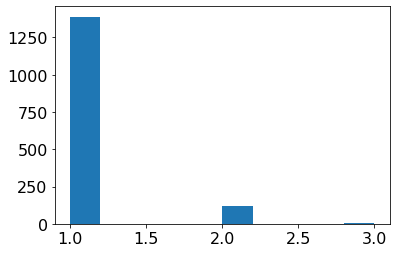

In [5]:
numpeaks = []
time_last_peak = []
N = 5000
for i in parameters_df.id.unique():
    ind_params = GetParams(parameters_df, i, style = 'mode')
    params_dict = {**fixed_params, **ind_params}
    tzero = -params_dict['tzero']
    t,y = Simulate(deriv, param_order, params_dict, init, 50+tzero, N);
    t = t - t[0]
    I = y[:,3]
    V = y[:,4]
    peaks, props = find_peaks(np.log10(np.maximum(V,200)), height = 3, prominence = 1)
    numpeaks.append(len(peaks))
    if len(peaks) > 1:
        time_last_peak.append(t[peaks[-1]])
    else:
        time_last_peak.append(t[peaks])
parameters_df['NumPeaks'] = numpeaks    
parameters_df['TimeToLastPeak'] = time_last_peak
plt.hist(numpeaks);
print(str(np.round(100*np.sum(1*(np.array(numpeaks)>1))/len(parameters_df.id.unique())))+'%')

median time to 2nd peak:  15.183036607321466


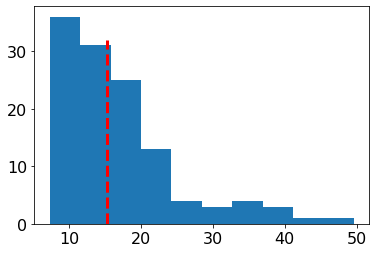

In [6]:
thresh = np.median(parameters_df[parameters_df['NumPeaks']>1].TimeToLastPeak)
ReboundGroups = []
for num, time in zip(numpeaks, time_last_peak):
    if num <=1:
        ReboundGroups.append(0)
    else:
        ReboundGroups.append(1)
        
parameters_df['Rebound'] = ReboundGroups
print('median time to 2nd peak: ', thresh)
plt.hist(parameters_df[parameters_df.Rebound>0].TimeToLastPeak)
plt.vlines(x = np.median(parameters_df[parameters_df.Rebound>0].TimeToLastPeak), ymin = 0, ymax = 32,color='r',ls ='--', linewidth = 3)

## Look at mechanistic differences between rebound and non-rebound groups

In [7]:
# Simulate everyone and save output
N = 5000
X = np.zeros((len(IDs),N))
T = np.zeros((len(IDs),N))
S_ = np.zeros((len(IDs),N))
R_ = np.zeros((len(IDs),N))
E_ = np.zeros((len(IDs),N))
I_ = np.zeros((len(IDs),N))
V_ = np.zeros((len(IDs),N))

for count, i in enumerate(IDs):
    ind_params = GetParams(parameters_df, i, style = 'mode')
    params_dict = {**fixed_params, **ind_params}
    tzero = -params_dict['tzero']
    t,y = Simulate(deriv, param_order, params_dict, init, 50+tzero, N);
    t = t - t[0]
    S = y[:,0]
    R = y[:,1]
    E = y[:,2]
    I = y[:,3]
    V = y[:,4]

    X[count,:] = np.log10(np.maximum(V,200))
    T[count,:] = t
    S_[count,:] = S
    R_[count,:] = R
    E_[count,:] = E
    I_[count,:] = I
    V_[count,:] = V
    

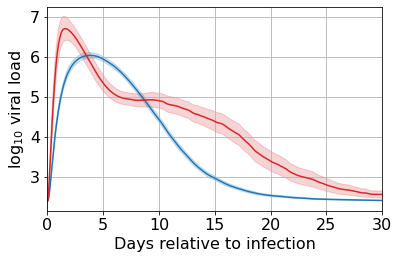

In [8]:
data = np.log10(np.maximum(V_,250))
colors = ['tab:blue','tab:red']
fig, ax = plt.subplots(figsize = (6,3.75))

for ii in [0,1]:
    data1 = data[parameters_df.Rebound == ii]
    CI_low = []
    CI_high = []
    for i in np.arange(0,5000):
        ans = st.norm.interval(alpha=0.95, loc=np.mean(data1[:,i]), scale=st.sem(data1[:,i]))
        CI_low.append(ans[0])
        CI_high.append(ans[1])
  
    plt.fill_between(t, CI_low, CI_high,color = colors[ii],alpha = .2)
    plt.plot(t,np.mean(data1, axis = 0), color = colors[ii])
    plt.xlabel('Days relative to infection')
    plt.ylabel(r'log$_{10}$ viral load')


plt.xlim([0,30])
major_ticks = np.arange(2, 8, 1)
plt.xticks = major_ticks
plt.grid(which='major')  

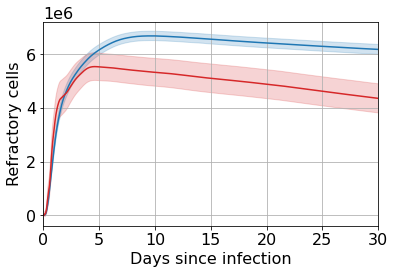

In [9]:
data = R_
colors = ['tab:blue','tab:red']
fig, ax = plt.subplots(figsize = (6,3.75))
for ii in np.arange(0,2):
    data1 = data[parameters_df.Rebound == ii]
    CI_low = []
    CI_high = []
    for i in np.arange(0,5000):
        ans = st.norm.interval(alpha=0.95, loc=np.mean(data1[:,i]), scale=st.sem(data1[:,i]))
        CI_low.append(ans[0])
        CI_high.append(ans[1])
    plt.grid()    
    plt.fill_between(t, CI_low, CI_high,color = colors[ii],alpha = .2)
    plt.plot(t,np.mean(data1, axis = 0), color = colors[ii])
    plt.xlim([0,30])
    plt.xlabel('Days since infection')
    plt.ylabel('Refractory cells')
plt.grid()


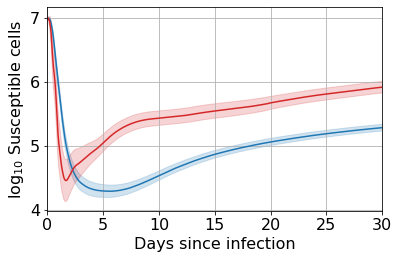

In [10]:
data = np.log10(S_)
colors = ['tab:blue','tab:red']
fig, ax = plt.subplots(figsize = (6,3.75))
for ii in np.arange(0,2):
    data1 = data[parameters_df.Rebound == ii]
    CI_low = []
    CI_high = []
    for i in np.arange(0,5000):
        ans = st.norm.interval(alpha=0.95, loc=np.mean(data1[:,i]), scale=st.sem(data1[:,i]))
        CI_low.append(ans[0])
        CI_high.append(ans[1])
    plt.grid()    
    plt.fill_between(t, CI_low, CI_high,color = colors[ii],alpha = .2)
    plt.plot(t,np.mean(data1, axis = 0), color = colors[ii])
    plt.xlim([0,30])
    plt.xlabel('Days since infection')
    plt.ylabel(r'log$_{10}$ Susceptible cells')
plt.grid()

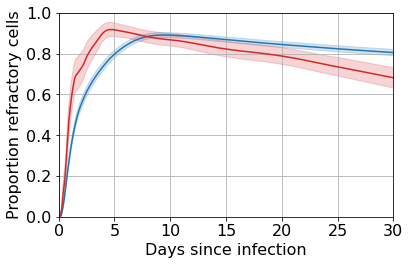

In [11]:
data = R_/(R_+S_)
colors = ['tab:blue','tab:red']
fig, ax = plt.subplots(figsize = (6,3.75))
for ii in np.arange(0,2):
    data1 = data[parameters_df.Rebound == ii]
    CI_low = []
    CI_high = []
    for i in np.arange(0,5000):
        ans = st.norm.interval(alpha=0.95, loc=np.mean(data1[:,i]), scale=st.sem(data1[:,i]))
        CI_low.append(ans[0])
        CI_high.append(ans[1])
    plt.grid()    
    plt.fill_between(t, CI_low, CI_high,color = colors[ii],alpha = .2)
    plt.plot(t,np.mean(data1, axis = 0), color = colors[ii])
    plt.xlim([0,30])
    plt.xlabel('Days since infection')
    plt.ylabel('Proportion refractory cells')
    plt.ylim([0,1])
plt.grid()

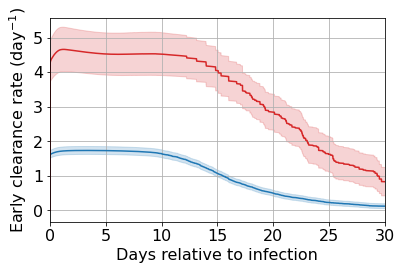

In [12]:
fig, ax = plt.subplots(figsize = (6,3.75))
data = [delta*np.maximum(I,1e-16)**h*(I>1e-7) for (delta,I,h) in zip(parameters_df['delta_mode'],I_,parameters_df['h_mode'])] 
data = np.concatenate(data)
data = np.reshape(data, (len(parameters_df),5000))
colors = ['tab:blue','tab:red']

for ii in np.arange(0,2):
    data1 = data[parameters_df.Rebound == ii]
    CI_low = []
    CI_high = []
    for i in np.arange(0,5000):
        ans = st.norm.interval(alpha=0.95, loc=np.mean(data1[:,i]), scale=st.sem(data1[:,i]))
        CI_low.append(ans[0])
        CI_high.append(ans[1])  
    plt.fill_between(t, CI_low, CI_high,color = colors[ii],alpha = .2)
    plt.plot(t,np.mean(data1, axis = 0), color = colors[ii])
    plt.xlabel('Days relative to infection')
    plt.ylabel(r'Early clearance rate (day$^{-1}$)')
    plt.xlim([0,30])
plt.grid()  

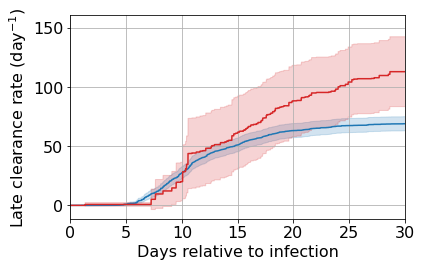

In [13]:
fig, ax = plt.subplots(figsize = (6,3.75))
data = [m*1*(t > tAI+t0) for (m,t0,tAI) in zip(parameters_df['m_mode'],parameters_df['tzero_mode'],parameters_df['tAI_mode'])] 
data = np.concatenate(data)
data = np.reshape(data, (len(parameters_df),5000))
colors = ['tab:blue','tab:red']

for ii in np.arange(0,2):
    data1 = data[parameters_df.Rebound == ii]
    CI_low = []
    CI_high = []
    for i in np.arange(0,5000):
        ans = st.norm.interval(alpha=0.95, loc=np.mean(data1[:,i]), scale=st.sem(data1[:,i]))
        CI_low.append(ans[0])
        CI_high.append(ans[1])    
    plt.fill_between(t, CI_low, CI_high,color = colors[ii],alpha = .2)
    plt.plot(t,np.mean(data1, axis = 0), color = colors[ii])
    plt.xlim([0,30])
    plt.xlabel('Days relative to infection')
    plt.ylabel(r'Late clearance rate (day$^{-1}$)')
    
plt.grid()

## Consider differences in parameter values

In [14]:
import seaborn as sns

adjusted_tAI = [t0+tAI for t0,tAI in zip(parameters_df.tzero_mode,parameters_df.tAI_mode)]
parameters_df['Adjusted_tAI'] = adjusted_tAI


def BoxPlot(df, feature, ylabel = [], yaxis = 'linear', ylim = [], annotate = True):
    all_data = []
    labels = ['No', 'Yes']
    colors = ['tab:blue', 'tab:red']
    sns.set(style='ticks')
    # Actual plotting
    fig = plt.figure(figsize=(4,4), dpi=72, facecolor="white")
    plt.rcParams.update({'font.size': 20})
    axes = plt.subplot(111)
    for i,l in enumerate(labels):
        temp = df[df.Rebound == i][feature]
        y = temp.tolist()
        x = np.random.normal(1+i, 0.06, size=len(y))
        if yaxis == 'linear':
            all_data.append(y)
            plt.plot(x, y, '^',color = colors[i], alpha=0.2, markersize = 5)
        elif yaxis == 'log':
            all_data.append(np.log10(y))
            plt.plot(x, np.log10(y), '^',color = colors[i], alpha=0.2, markersize = 5)
            
    boxprops = dict(color="black",linewidth=1.8)
    medianprops = dict(color="black",linewidth=2.25)
    plt.boxplot(all_data, labels=labels,boxprops=boxprops,medianprops=medianprops);
    if ylim:
        plt.ylim(ylim)
    sns.despine(ax=axes, offset=10, trim=True)
    axes.tick_params(axis='both', which='major', labelsize=18)
    t = mannwhitneyu(all_data[1], all_data[0]).pvalue
    bc = 9
    if annotate:
        if t > 0.05/bc:
            stat = 'ns'
            plt.title(stat, fontsize = 14)
        elif t > .01/bc:
            stat = '*'
            plt.title(stat, fontsize = 20)
        elif t > 1e-3/bc:
            stat = '**'
            plt.title(stat, fontsize = 20)
        elif t > 1e-4/bc:
            stat = '***'
            plt.title(stat, fontsize = 20)
        else:
            stat = '****'
            plt.title(stat, fontsize = 20)

    if ylabel:
        plt.ylabel(ylabel, fontsize = 20)
        #
    else:
        plt.ylabel(feature, fontsize = 20)
    fig.tight_layout()
    plt.show()
    return None

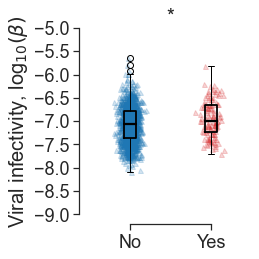

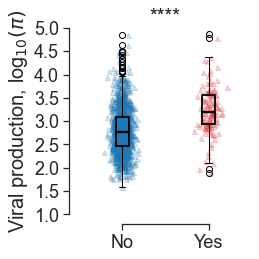

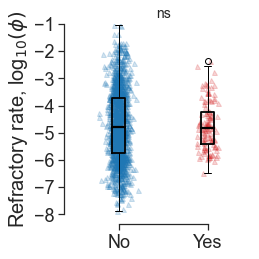

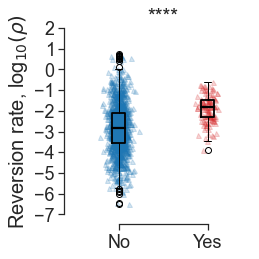

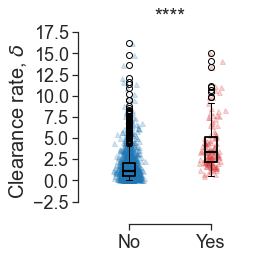

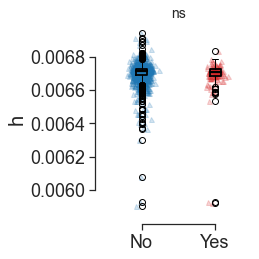

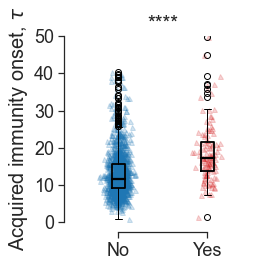

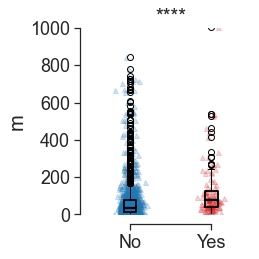

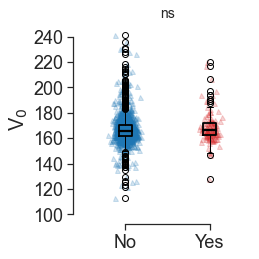

In [15]:
# -- Plot all parameters
parameters = [ 'log10beta_mode','log10pi_mode', 'log10phi_mode','log10rho_mode', 
              'delta_mode','h_mode','Adjusted_tAI','m_mode', 'V0_mode']
labels = [r'Viral infectivity, log$_{10}(\beta)$', 
          r'Viral production, log$_{10}(\pi)$', r'Refractory rate, log$_{10}(\phi)$',
          r'Reversion rate, log$_{10}(\rho)$', r'Clearance rate, $\delta$','h',
          r'Acquired immunity onset, $\tau$','m', 'V$_0$']
ylims = [[-9,-5],[1,5],[-8,-1],[-7, 2],[-4,18],[],[0,50], [0,1000],[100,250]]
for p,l,y in zip(parameters,labels, ylims):

    BoxPlot(parameters_df, p, ylabel = l, ylim = y, annotate = True)

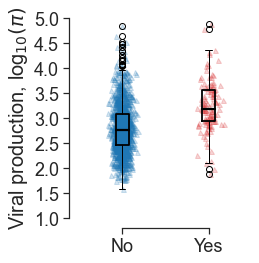

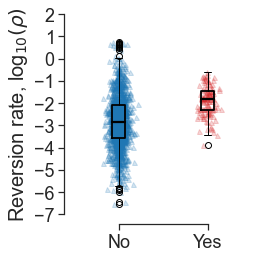

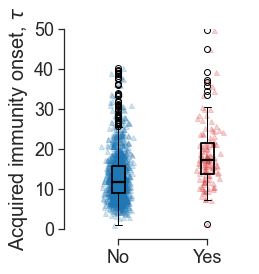

In [16]:
# Plot only statistically significant 
parameters = [ 'log10pi_mode', 'log10rho_mode', 'Adjusted_tAI']
labels = [ r'Viral production, log$_{10}(\pi)$', r'Reversion rate, log$_{10}(\rho)$', r'Acquired immunity onset, $\tau$',]
ylims = [[1,5],[-7, 2],[0,50]]
for p,l,y in zip(parameters,labels, ylims):
    BoxPlot(parameters_df, p, ylabel = l, ylim = y, annotate = False)

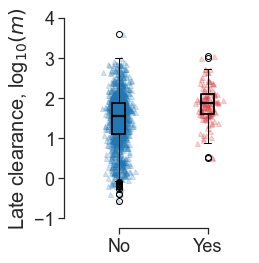

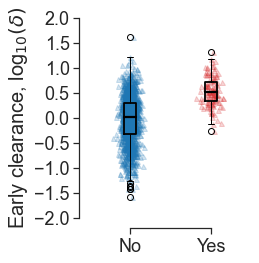

In [17]:
# switch delta and m to a log scale
parameters_df['log10m_mode'] = [np.log10(m) for m in parameters_df['m_mode']]
BoxPlot(parameters_df, 'log10m_mode', ylabel = r'Late clearance, log$_{10}(m)$', ylim = [-1,4], annotate = False)

parameters_df['log10delta_mode'] = [np.log10(m) for m in parameters_df['delta_mode']]
BoxPlot(parameters_df, 'log10delta_mode', ylabel = r'Early clearance, log$_{10}(\delta)$', ylim = [-2,2], annotate = False)

### Check model simulations for cases flagged as rebound by Hay et al.'s criteria.

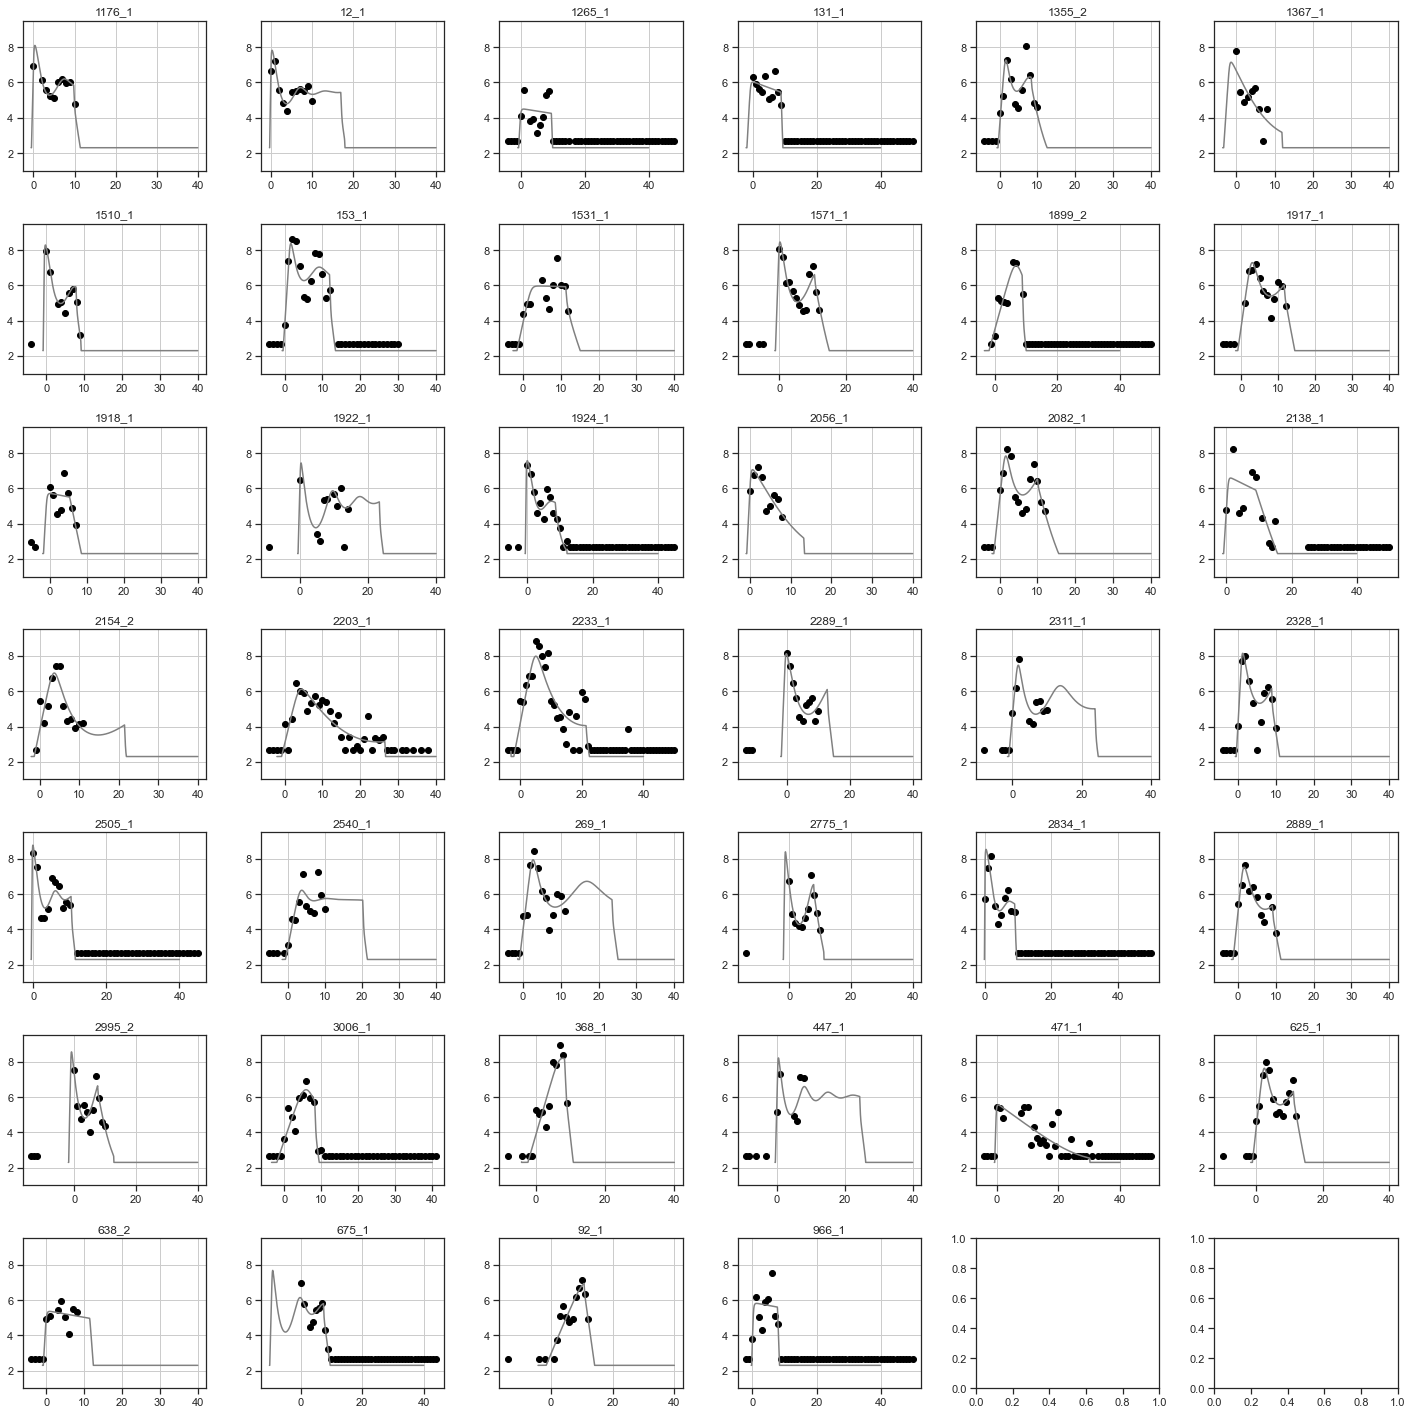

In [18]:
KisslerFigureRebound = ['1176_1', '12_1', '1265_1','131_1', '1355_2','1367_1',
                       '1510_1', '153_1','1531_1', '1571_1', '1899_2','1917_1',
                       '1918_1','1922_1', '1924_1', '2056_1','2082_1', '2138_1',
                       '2154_2', '2203_1', '2233_1','2289_1','2311_1','2328_1',
                       '2505_1','2540_1', '269_1','2775_1','2834_1','2889_1',
                       '2995_2','3006_1','368_1', '447_1', '471_1', '625_1',
                       '638_2','675_1','92_1','966_1']

plt.rcParams.update({'font.size': 18})
count = 0
fig, ax = plt.subplots(7,6, figsize =(20,20))
for j in range(0,7):
    for jj in range(0,6):
        if count < len(KisslerFigureRebound):
            try:
                ID = KisslerFigureRebound[count]
                ind_params = GetParams(parameters_df, ID, style = 'mode')
                params_dict = {**fixed_params, **ind_params}
                t,y = Simulate(deriv, param_order, params_dict, init, 40, 10000)
                # identify data
                tdata = full_data_df[full_data_df['ID'] == ID].time
                temp = full_data_df[full_data_df['ID'] == ID].y
                ydata = [float(y) for y in temp]
                ax[j,jj].plot(tdata.values, ydata,'o', color = 'black')
                ax[j,jj].plot(t, np.log10(np.maximum(y[:,4],200)), color = 'gray')
                ax[j,jj].set_ylim(1,9.5)
                #ax[j,jj].set_xlim(-5,30)
                ax[j,jj].set_title(ID)
                ax[j,jj].grid()
                count = count + 1
            except:
                ax[j,jj].set_title(ID)
                count = count+1
                continue

plt.tight_layout()